In [1]:
import itertools
import os
import functools
import dataclasses
import packaging.version
from typing import List, Sequence, Set, Iterator, Optional

import libmambapy
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import mamba_error_reporting as mer

pd.set_option("max_colwidth", None)
pd.set_option("display.max_columns", None)

%matplotlib inline

## Previous error message

In [2]:
solver, pool = mer.problems.create_pytorch_cpu()
success = solver.solve()
if not success:
    print(mer.messaging.old_error_report(solver))

conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache
Mamba failed to solve. The reported errors are:
   Encountered problems while solving:
     - nothing provides __cuda needed by pytorch-1.11.0-cuda102py310hdf4a2db_202
   


## Raw libsolv data

In [3]:
pbs = mer.analysis.all_problems_structured_df(solver)
deps = mer.analysis.select_solvables_df(
    pool, pbs[~pbs.dependency.isnull()].dependency_id.drop_duplicates()
)
solvables = mer.analysis.id_to_pkg_info_df(pool,
    itertools.chain(
    pbs[pbs.source_is_pkg].source_id,
    pbs[pbs.target_is_pkg].target_id,
    deps.solvable_id
)).drop_duplicates().set_index('id').sort_index()

## Graph compression

==================================================== Original graph ====================================================


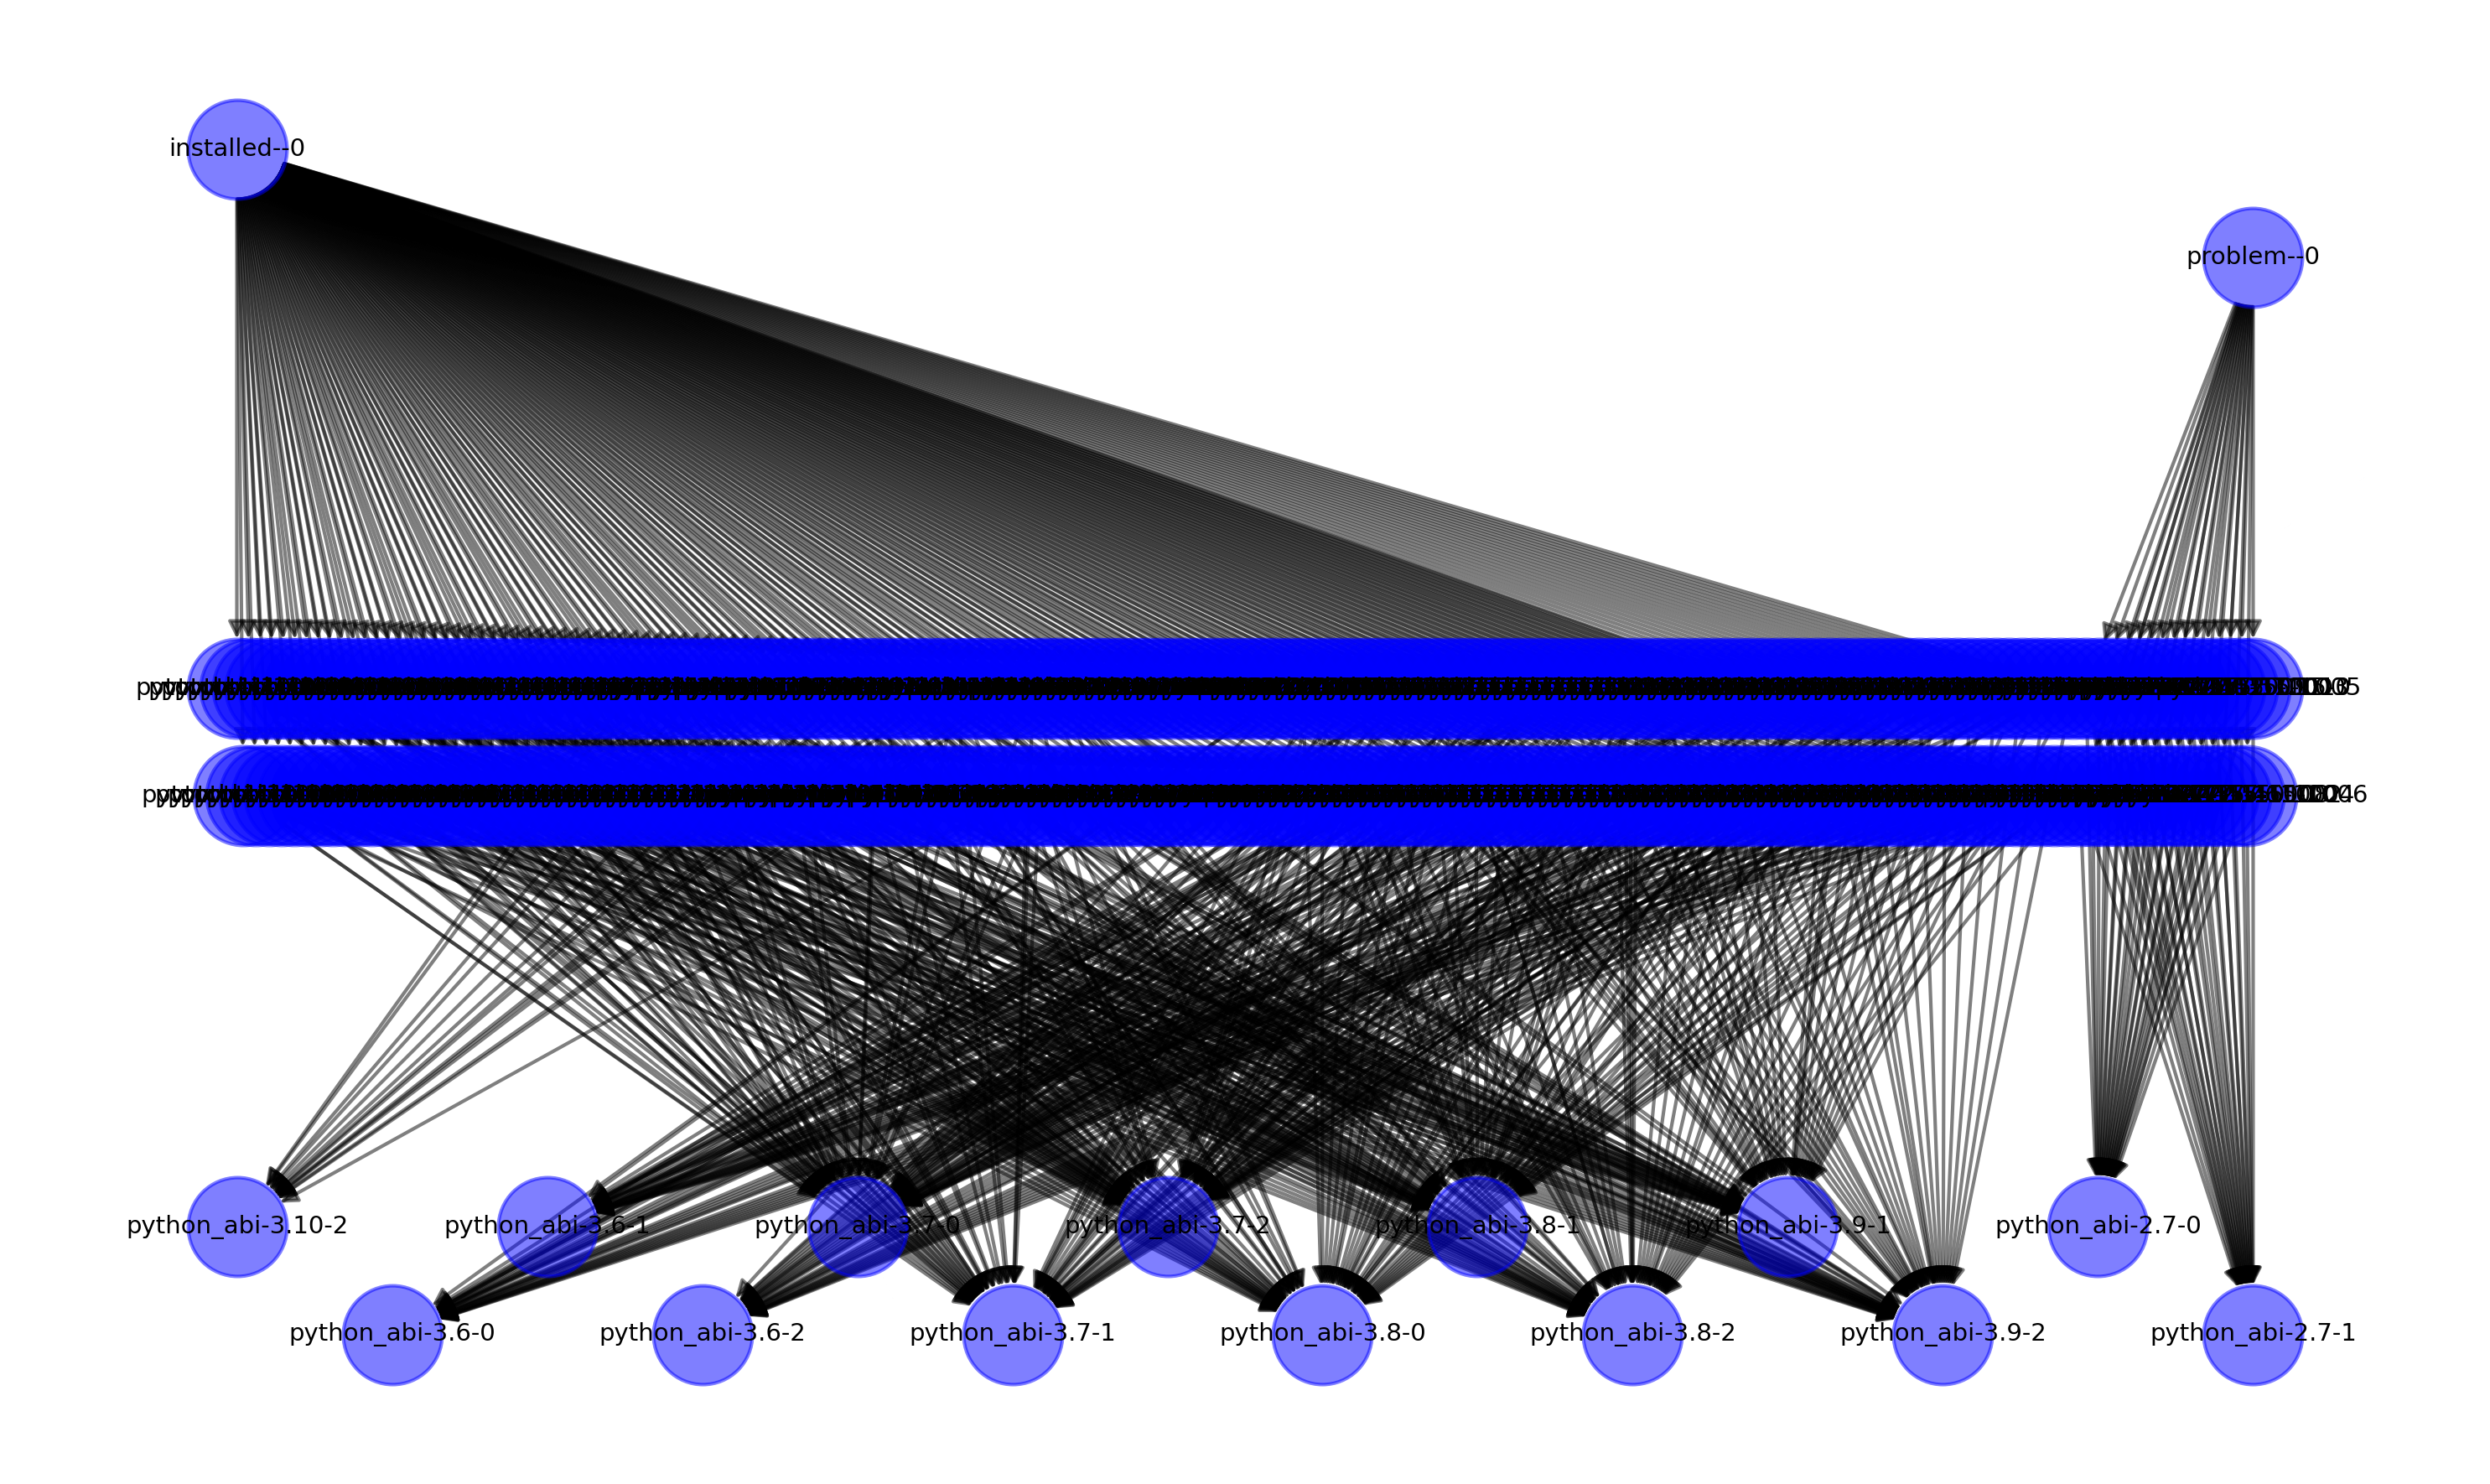

=================================================== Compressed graph ===================================================


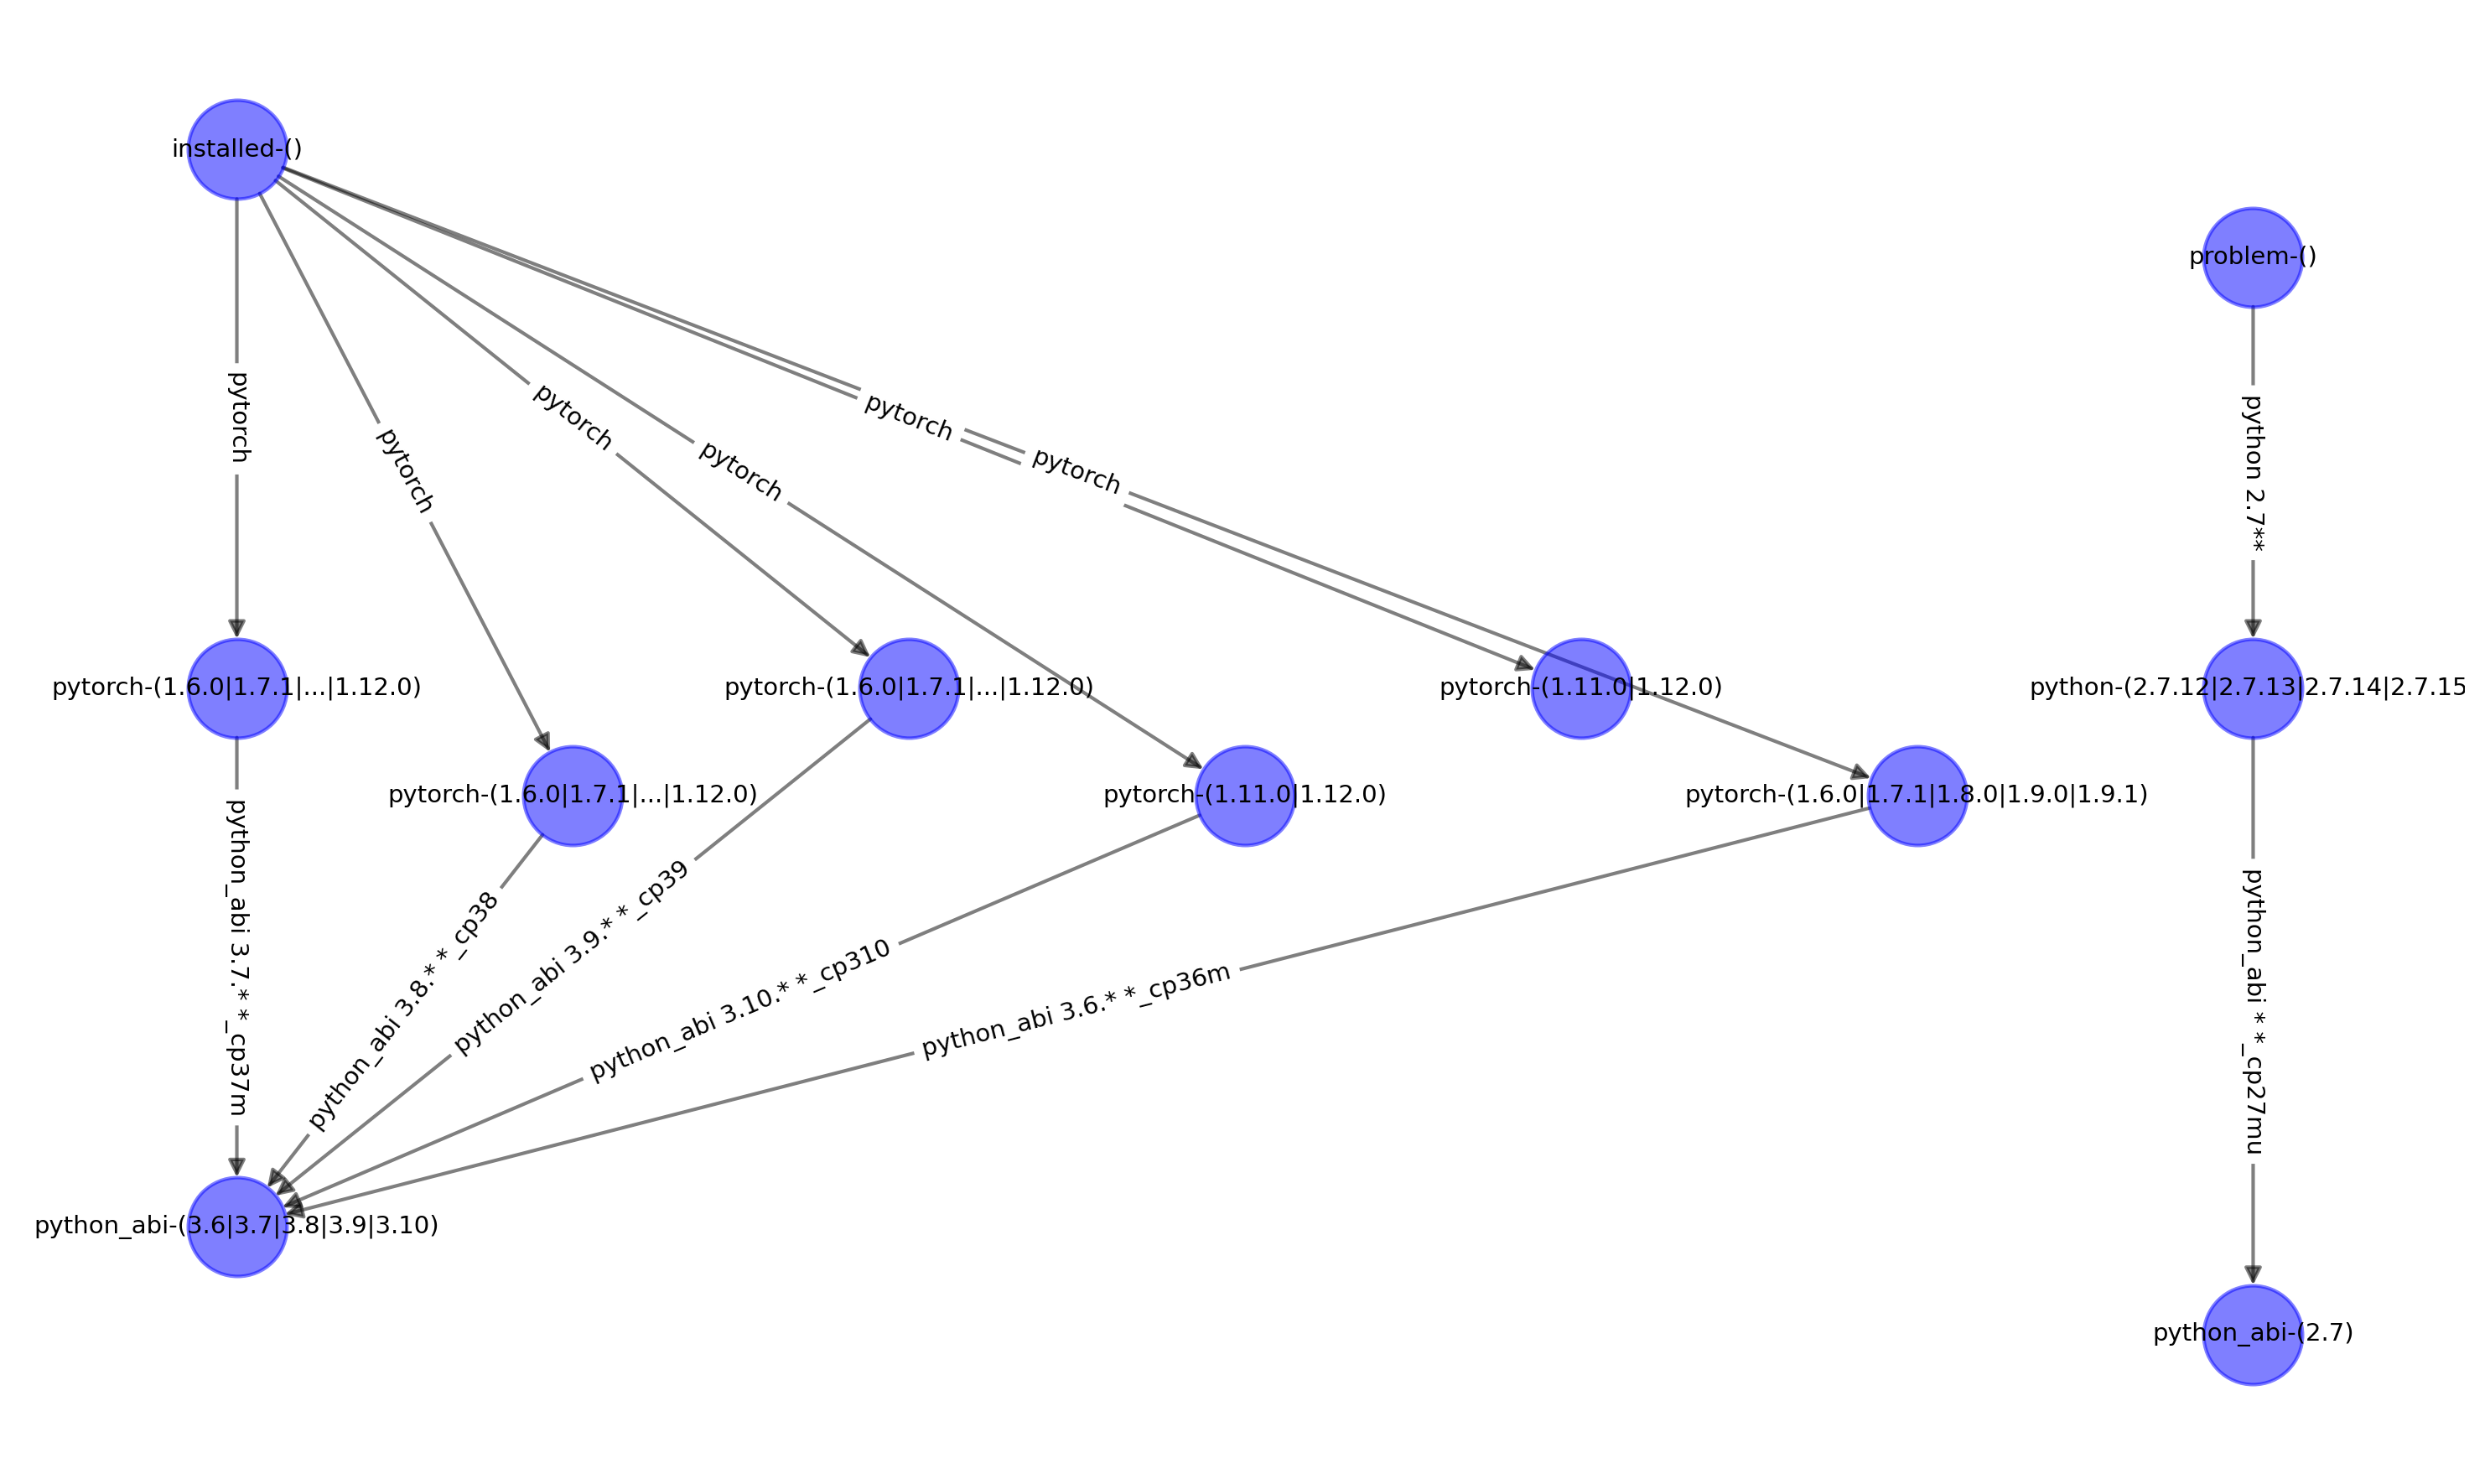

In [4]:
print("{:=^120}".format(" Original graph "))
pb_data = mer.algorithm.ProblemData.from_libsolv(solver, pool)
mer.plot.plot_solvable_dag(pb_data)
print("{:=^120}".format(" Compressed graph "))
cp_data = mer.algorithm.compress_graph(pb_data)
mer.plot.plot_group_dag(pb_data, cp_data)

## Error message

In [5]:
print(mer.algorithm.explain_graph(pb_data, cp_data))

Error: Could not install any versions from requested package python 2.7**.

  A package satisfying pytorch is requested, so one of the following versions must be installed
    pytorch [1.9.1|1.6.0|1.9.0|1.7.1|1.8.0], which requires
      python_abi 3.6.* *_cp36m, which could be installed;
    pytorch [1.12.0|1.11.0], which requires the non-existent package __cuda;
    pytorch [1.12.0|1.11.0], which requires
      python_abi 3.10.* *_cp310, which could be installed;
    pytorch [1.10.0|1.9.1|...|1.8.0|1.12.0], which requires
      python_abi 3.9.* *_cp39, which could be installed;
    pytorch [1.10.0|1.9.1|...|1.8.0|1.12.0], which requires
      python_abi 3.8.* *_cp38, which could be installed;
    pytorch [1.10.0|1.9.1|...|1.8.0|1.12.0], which requires
      python_abi 3.7.* *_cp37m, which could be installed.

  This implies that python 2.7** cannot be installed because it requires
    python_abi * *_cp27mu, which conflicts with any installable versions of python_abi.
